Title: Features and Descriptors
Author: Thomas Breuel
Institution: UniKL

In [1]:

figsize(12,6)

In [2]:
import cv2
from scipy import stats,spatial
from scipy.ndimage import filters,morphology,interpolation
AND=logical_and; OR=logical_or; NOT=logical_not
from scipy.spatial.distance import cdist
matplotlib.rc("image",cmap="gray")

def byteimage(image):
    if image.dtype==dtype('B'): return image
    return array(255*clip(image,0,1),'B')


# Feature Correspondences with Descriptors

Let's start with an example, two images of the Brandenburger Tor in Berlin. These show the same object under slightly different lighting coditions and orientations. We want to find corresponding points in each image.


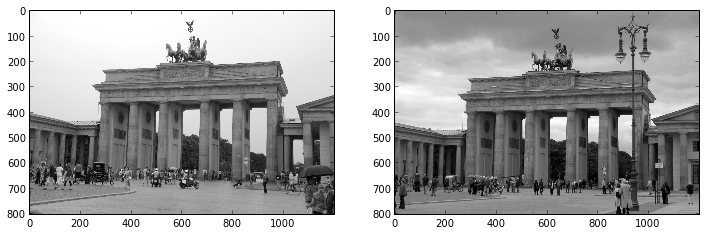

In [3]:
image1 = array(mean(imread("bbtor.jpg"),axis=2),'B')
image2 = array(mean(imread("bbtor2.jpg"),axis=2),'B')
subplot(121); imshow(image1); subplot(122); imshow(image2)

Example Applications:

- 3D reconstruction (stereometry)
- object recognition
- stitching
- resolution enhancement

OpenCV abstracts this process into:

- feature detectors: find interest points (like corners)
- feature descriptors: describe the neighborhood of each detected feature



In [ ]:
detector = cv2.FeatureDetector_create("SIFT")
descriptor = cv2.DescriptorExtractor_create("SIFT")

Feature detection and description is a two-step process:

- extract the location of image features
- compute the descriptor around each image feature

In [ ]:
kp1 = detector.detect(image1)
kp1,de1 = descriptor.compute(image1,kp1)
kp2 = detector.detect(image2)
kp2,de2 = descriptor.compute(image2,kp2)
print len(kp1),len(kp2)

Each detected feature is given as a _keypoint_.

The corresponding _descriptor_ is a floating point vector such that the distance in vector space is a dissimilarity measure.



In [ ]:
for k in "pt size angle response".split():
    print k,getattr(kp1[0],k)
    
print de1[0]

For finding corresponding points, we look for descriptor vectors that are as close as possible.

We can compute this with just the `cdist` and `argmin` functions in numpy:


In [ ]:
index = argmin(cdist(array(de2),array(de1)),axis=1)
for i in range(5): print i,index[i]

Alternatively, we can use the FLANN library, which computes nearest neighbors for large data sets faster, albeit at the cost of some percentage of errors:



In [ ]:
flann = cv2.flann_Index(de1,dict(algorithm=1,trees=4))
index,dist = flann.knnSearch(de2,1,params={})
del flann
index = array([l[0] for l in index])
dist = array([l[0] for l in dist])
for i in range(5): print i,index[i]

It is customary to show images side-by-side and link corresponding feature locations by lines:



In [ ]:
figsize(18,12)
h1,w1 = image1.shape
h2,w2 = image2.shape
combined = zeros((h1,w1+w2),'B')
combined[:,:w1] = image1
combined[:,w1:] = image2
axis("off")
imshow(combined)
best = argsort(dist)[:50]
for i,j in zip(best,index[best]):
    x1,y1 = kp1[j].pt
    x2,y2 = kp2[i].pt
    plot([x1,x2+w1],[y1,y2],color='red',alpha=0.5)

# Comparison of Detectors

Let's discuss and compare the various feature detectors now.

In [ ]:

detectors = "FAST STAR SIFT SURF ORB BRISK MSER GFTT HARRIS Dense SimpleBlob".split()
def showdetector(det,showsize=0):
    assert det in detectors
    detector = cv2.FeatureDetector_create(det)
    kp1 = detector.detect(image1)
    del detector
    rs = [p.response for p in kp1]
    best = [kp1[i] for i in argsort(rs)[::-1][:200]]
    axis("off")
    imshow(image1)
    for p in best:
        x,y = p.pt
        if showsize:
            gca().add_patch(Circle((x,y),radius=p.size,color='r',alpha=0.5))
        else:
            plot([x],[y],'ro')

FAST corner detector:

- features from accelerated segment test
- look at an arc around a central pixel and determine whether that arc is brighter by some threshold
- (this is essentially a grayscale morphology edge detector)
- apply machine learning to improve detection
- perform non-maximum suppression

![illustration of corner detector](http://www.edwardrosten.com/work/corner.png)

In [ ]:
showdetector("FAST")

STAR feature detector:

- center surround filters, similar to Laplacian
- compute accross multiple scales
- look for extrema

In [ ]:
showdetector("STAR")

SIFT detector:

- difference of Gaussians at multiple scales
- pick local extrema in space and scale space

![scale invariance](http://www.clipular.com/c?5517589698576384=WSGttxTfD-FCYAcTqYBMYugQcgw&f=.png)

In [ ]:
showdetector("SIFT")

In [ ]:
showdetector("SIFT",showsize=1)

SURF feature extractor:

- similar to SIFT detectors
- uses Haar wavelets and integral images

![Haar wavelets](http://goo.gl/rPZUyN)

![summed area tables](http://upload.wikimedia.org/wikipedia/commons/e/ee/Prm_VJ_fig3_computeRectangleWithAlpha.png)

Summed Area Tables / Integral Images

In [ ]:
showdetector("SURF")

In [ ]:
showdetector("SURF",showsize=1)

ORB feature detector:
    
- uses FAST corner detection in pyramids
- selects strongest features using FAST or Harris response
- finds orientation using first-order moments
- meant to be used with BRIEF descriptor

In [ ]:
showdetector("ORB")

BRISK keypoint detector:

- variant of FAST for keypoint detection
- uses FAST response for strength
- scale estimation in continuous scale space

In [ ]:
showdetector("BRISK")

MSER keypoint detector:

- maximally stable extremal regions
- compute a sequence of thresholds
- stability means small changes in threshold imply small changes in region 
- maximum stability = regions that are stable of large changes in thresholds

In [ ]:
showdetector("MSER")

In [ ]:
showdetector("MSER",showsize=1)

In [ ]:
# good features to track, as selected by OpenCV
showdetector("GFTT")

In [ ]:
# Harris corner detector
showdetector("HARRIS")

In [ ]:
# dense sampling of points
showdetector("Dense")

Simple Blob Detector:

- perform thresholding
- find connected regions and their centroids
- select subset of blobs based on circularity, area, convexity, color uniformity

In [ ]:
showdetector("SimpleBlob")

# Evaluation

Generally, we want feature detectors and descriptors to accomplish multiple things:

- matching corresponding points
- not matching non-corresponding points
- localizing feature points accurately and reproducibly

We need to make tradeoffs.

Invariances:

Detector and descriptor design is often based on considerations of what image transformations we want descriptors to be (partially) invariant under:

- 2D translation
- 2D rotation
- 3D object rotation
- affine transformations
- changes in scale
- changes in exposure
- changes in illumination
- changes in color
- addition of noise

Invariances:

More invariance is not necessarily better, because it also means that more things become confusable.

E.g., if I know that images are going to be recognized right side up, 2D rotation invariance makes performance worse, not better.

The degree of invariance that is useful also depends on the _size_ of the data sets we are comparing:

- image-to-image comparisons (resolution-dependent)
- image-to-image-database comparisons (number of images and their resolutions)

Benchmarking of detectors and descriptors:

Each feature detector and descriptor makes a particular choice of what it is and is not invariant to.

Whether these choices work well or not depends on the application and the exact set of images; there is no "optimal" feature detector for all applications.

Are benchmarks worthless?:

Some descriptors are uniformly better than others, across a wide range of conditions and measures.

If a descriptor is worse than another on some reasonable benchmark, then it can't be uniformly better across all conditions.

Careful benchmarking should be viewed more as a characterization of descriptors than as an evaluation.

Applications:

Think about applications and the invariances they imply:

- feature tracking in video
- stereo
- wide baseline stereo
- stitching
- object recognition

Each of these implies different kinds of (partial) invariances.

# Comparison of Detectors and Descriptors

Showing Matches:

Let's look at the performance of matching in practice.

- start with two images of the same subject under slightly different conditions
- use the same interest point detector (Harris corners)
- use different descriptors (we'll get to them later)
- find the top 50 best matching descriptors
- plot the correspondence

Disclaimer:

- this kind of comparison is tricky
- orientation and scale detection and descriptor may need to be matched
- matching across scales may or may not be desired, and may give rise to errors
- for true evaluation, need performance across many images

In [ ]:

descriptors = "SIFT SURF BRIEF BRISK ORB FREAK".split()

def showmatch(det,desc):
    assert det in detectors
    assert desc in descriptors
    detector = cv2.FeatureDetector_create(det)
    descriptor = cv2.DescriptorExtractor_create(desc)
    kp1 = detector.detect(image1)
    kp1,de1 = descriptor.compute(image1,kp1)
    kp2 = detector.detect(image2)
    kp2,de2 = descriptor.compute(image2,kp2)
    print len(kp1),len(kp2)
    if de1.dtype!=dtype('f'): de1 = array(de1,'f')
    if de2.dtype!=dtype('f'): de2 = array(de2,'f')
    flann = cv2.flann_Index(de1,dict(algorithm=1,trees=4))
    index,dist = flann.knnSearch(de2,1,params={})
    del flann
    index = array([l[0] for l in index])
    dist = array([l[0] for l in dist])
    figsize(18,12)
    h1,w1 = image1.shape
    h2,w2 = image2.shape
    combined = zeros((h1,w1+w2),'B')
    combined[:,:w1] = image1
    combined[:,w1:] = image2
    axis("off")
    imshow(combined)
    best = argsort(dist)[:50]
    for i,j in zip(best,index[best]):
        x1,y1 = kp1[j].pt
        x2,y2 = kp2[i].pt
        plot([x1,x2+w1],[y1,y2],color='red',alpha=0.5)

SIFT descriptors:

- uses scale and orientation from interest point detector
- places a 4x4 rotated grid around the interest point at the given scale
- computes an orientation histogram at 8 orientations in each bin
- 4x4x8 = 128-dimensional descriptor

In [ ]:
showmatch("HARRIS","SIFT")

SURF descriptor:

- 4x4 subregions
- sums of $g_x$, $|g_x|$, $g_y$, and $|g_y|$ over each subregion
- wavelet features

In [ ]:
showmatch("HARRIS","SURF")

BRIEF descriptor:

- Binary Robust Independent Elementary Features
- binary descriptor of image intensities
- pairwise comparison of intensities in original and smoothed image
- locations of pairwise tests selected at random
- matching by Hamming distance

In [ ]:
showmatch("HARRIS","BRIEF")

BRISK descriptor:

- Binary Robust Invariant Scalable Keypoints
- criticizes BRIEF for lack of robustness to transformations
- adds scalespace keypoint detection
- normalizes for rotation
- uses concentric circles with different resolutions for sampling pattern
- matching by Hamming distance

In [ ]:
showmatch("HARRIS","BRISK")

ORB descriptor:

- an efficient alternative to SIFT, SURF
- adds orientation component to FAST
- computes oriented BRIEF features quickly
- decorrelates BRIEF features

In [ ]:
showmatch("HARRIS","ORB")

FREAK descriptor:

- fast Retina keypoint descriptor
- binary descriptor
- retinal sampling pattern
- small filters at center, large filters further out
- saccadic search

In [ ]:
showmatch("HARRIS","FREAK")

# Evaluation of Detectors

We want to evaluate feature detectors. Because we want to evaluate them for rotational invariance, let's construct a test image that we can rotate without losing features while still being able to rotate detected features back (we'll see later how that works). To do this, we make the image square and put a circular window with a smooth border on top of it.



In [ ]:
test = image1[0:800,200:1000]/255.0
y,x = mgrid[:800,:800]
mask = 1.0*((y-400)**2+(x-400)**2<=350**2)
gmask = filters.gaussian_filter(mask,20.0)
test = array(test*gmask[:,:],'f')
imshow(test)

Since we're going to extract features a lot, let's define a feature extractor. OpenCV crashes if we ask for a non-existent detector, so let's make sure we only allow valid descriptors.



In [ ]:
detectors = "FAST STAR SIFT SURF ORB BRISK MSER GFTT HARRIS Dense SimpleBlob".split()

def detect_features(image,n=300,det="HARRIS"):
    if image.dtype!=dtype('B'):
        image = array(clip(image,0,1)*255,'B')
    assert det in detectors
    detector = cv2.FeatureDetector_create(det)
    kp = detector.detect(image)
    del detector
    rs = [p.response for p in kp]
    return [kp[i].pt for i in argsort(rs)[::-1][:n]]

Feature detection works on the new test image. Note that there are no spurious features due to the window.



In [ ]:
imshow(test)
features = detect_features(test)
axis("off")
for x,y in features: plot([x],[y],'ro')

NOTE:
    
Testing these detectors and descriptors on a single image is not sufficient for a good evaluation.

For a real evaluation, we would need to construct a collection of a few thousand representative images, run the tests below on all of them, and average the results.

## Speed

In [ ]:
import timeit
btest = byteimage(test)
for det in detectors:
    detector = cv2.FeatureDetector_create(det)
    print "%20s %.2f"%(det,timeit.timeit(lambda: detector.detect(btest),number=10))
    del detector

## Coverage

Feature detectors are better if they cover more of the image, i.e., if they detect features all over the image. Here is a simple function for testing that.



In [ ]:
def coverage(points,r=20):
    loc = zeros(mask.shape)
    for x,y in points: loc[y,x] = 1
    loc = AND(mask,morphology.binary_dilation(loc,iterations=r))
    return sum(loc)*1.0/sum(mask)

There is considerable variability in the coverage of feature detectors.



In [ ]:
for det in detectors:
    features = detect_features(test,det=det,n=100)
    print "%20s %.3f"%(det,coverage(features))

## Robustness to Noise

We also want feature detectors to be robust to noise (and other image transformations). We check as follows:

- detect features in the original image
- transform the image in some way
- detect featuers again
- determine how many features are still detected in the same location

We detect the 100 strongest feature points in the original image and the 200 strongest feature points in the transformed image, allowing degradation to degrade the ranking of some feature points relative to others.

The score is the fraction of the strongest feature points in the original image that are still among those detected in the degraded image.

In [ ]:
def percent_match(points1,points2,d=2.0):
    if len(points1)<2 or len(points2)<2: return 0.0
    points1 = array(points1)
    points2 = array(points2)
    d1 = amin(cdist(points1,points2),axis=1)
    return sum(d1<d)*1.0/len(d1)

In [ ]:
points1 = detect_features(test,det="HARRIS",n=100)
points2 = detect_features(test+0.1*randn(*test.shape),det="HARRIS",n=200)
percent_match(points1,points2)

A good criterion is the amount of noise that can be added before the percentage of matching features falls below some predetermined threshold.

This may also depend on the spectrum of the noise being added.



In [ ]:
def noiseimage(shape,sigma=1.0):
    nimage = filters.gaussian_filter(randn(*shape),sigma)
    nimage /= var(nimage)**.5
    return nimage

def maxnoise(det,threshold=0.5,n=300,sigma=1.0):
    for noise in linspace(0.0,1.0,101.0):
        points1 = detect_features(test,det=det,n=n)
        points2 = detect_features(test+noise*noiseimage(test.shape,sigma=sigma),det=det,n=n)
        if percent_match(points1,points2)<threshold: return noise
    return 1.0

maxnoise("HARRIS")

In [ ]:
for det in detectors:
    print "%20s %.2f %.2f %.2f %.2f"%(det,maxnoise(det=det,sigma=0.0),maxnoise(det=det,sigma=1.0),maxnoise(det=det,sigma=2.0),maxnoise(det=det,sigma=4.0))

## Sensitivity to Gamma

We want feature detection to be robust to non-linear transformations of intensity. There are many transfer curves one should look at, but here, we are testing simply with different gammas.



In [ ]:
def maxgamma(det,threshold=0.5,n=300):
    for gamma in linspace(1.0,5.0,41.0):
        points1 = detect_features(test,det=det,n=n)
        points2 = detect_features(test**gamma,det=det,n=n)
        if len(points1)<2 or len(points2)<2: return gamma
        if percent_match(points1,points2)<threshold: return gamma
    return 99.0

maxgamma("HARRIS")

In [ ]:
for det in detectors:
    print "%20s %.2f"%(det,maxgamma(det=det))

## Sensitivity to Blurring

Since different images may have different amounts of focus, we may want feature detectors to be robust to some amount of blurring.


In [ ]:
def maxblur(det,threshold=0.5,n=300):
    for sigma in linspace(0.0,5.0,11):
        points1 = detect_features(test,det=det,n=n)
        points2 = detect_features(filters.gaussian_filter(test,sigma),det=det,n=n)
        if percent_match(points1,points2)<threshold: return sigma
    return 99.0

maxblur("HARRIS")

In [ ]:
for det in detectors:
    print "%20s %.2f"%(det,maxgamma(det=det))

## Sensitivity to Rotation

We also want feature detectors to be robust under rotation. To do that, we detect features in the original and rotated image. We transform back the rotated features, and then match as before.



In [ ]:
def rotate_points(points,a):
    a = a*pi/180.0
    result = []
    for x,y in points:
        x -= 400; y -= 400
        x1 = cos(a)*x-sin(a)*y
        y1 = sin(a)*x+cos(a)*y
        x1 += 400; y1 += 400
        result.append((x1,y1))
    return result

In [ ]:
points1 = detect_features(test,det="HARRIS",n=100)
axis("off"); imshow(test)
for x,y in points1: plot([x],[y],'ro')

In [ ]:
rtest = interpolation.rotate(test,40,reshape=0)
points2 = detect_features(rtest,det="HARRIS",n=200)
axis("off"); imshow(rtest)
for x,y in points2: plot([x],[y],'ro')

In [ ]:
points2r = rotate_points(points2,40.0)
axis("off"); imshow(test)
for x,y in points2r: plot([x],[y],'ro')

In [ ]:
percent_match(points1,points2r)

In [ ]:
def rotation_invariance(angle,det="HARRIS"):
    points1 = detect_features(test,det=det,n=100)
    rtest = interpolation.rotate(test,angle,reshape=0)
    points2 = detect_features(rtest,det=det,n=100)
    points2r = rotate_points(points2,angle)
    return percent_match(points1,points2r)

def rotation_invariances(det="HARRIS"):
    r = [rotation_invariance(a,det=det) for a in linspace(0.0,90.0,10)]
    return amin(r)

rotation_invariances()

In [ ]:
for det in detectors:
    print "%20s %.2f"%(det,rotation_invariances(det=det))

# Robustness of Descriptors

## Robustness to Noise

In [ ]:
detector = cv2.FeatureDetector_create("SIFT")
keypoints = detector.detect(byteimage(test))
del detector
order = argsort([p.response for p in keypoints])[::-1][:100]
keypoints = [keypoints[i] for i in order]

In [ ]:
descriptors = "SIFT SURF BRIEF BRISK ORB FREAK".split()

def maxnoise(desc="SURF",sigma=2.0,n=100,threshold=0.3):
    global noise
    result = []
    for nval in linspace(0.0,1.0,11.0):
        assert desc in descriptors
        descriptor = cv2.DescriptorExtractor_create(desc)
        kp1,de1 = descriptor.compute(byteimage(test),keypoints)
        noise = filters.gaussian_filter(rand(*test.shape)-0.5,sigma)
        noise /= amax(abs(noise))
        noise *= nval
        kp2,de2 = descriptor.compute(byteimage(test+noise),keypoints)
        del descriptor
        error = sum(arange(len(de1))!=argmin(cdist(de1,de2),axis=1))*1.0/len(de1)
        if error>threshold: return nval
    return 99.9

maxnoise()

In [ ]:
for desc in "SIFT SURF BRIEF BRISK FREAK".split():
    print "%20s %.2f %.2f"%(desc,maxnoise(desc,sigma=0.0),maxnoise(desc,sigma=1.0))

## Behavior under Transformations

We may want descriptors to be robust under geometric transformations as well.

In particular:

- they should have some robustness to translation, since feature detection may have some variability
- they may need rotation invariance if we want to match features between rotated images

Note that rotation invariance is often achieved by using the orientation estimate from the feature detector.

In [ ]:
descriptors = "SIFT SURF BRIEF BRISK ORB FREAK".split()

def shift_dependence(desc="SURF",sigma=2.0,n=100,threshold=0.3):
    assert desc in descriptors
    global noise
    result = []
    for d in linspace(0.0,5.0,6):
        error = 0.0
        na = 2
        for a in linspace(0.0,pi/2,na):
            dx,dy = cos(a)*d,sin(a)*d
            assert desc in descriptors
            descriptor = cv2.DescriptorExtractor_create(desc)
            kp1,de1 = descriptor.compute(byteimage(test),keypoints)
            kp2,de2 = descriptor.compute(byteimage(interpolation.shift(test,(dx,dy))),keypoints)
            del descriptor
            e = sum((de1-de2)**2) / len(de1)
            error += e
        result.append((d,error/na))
    return array(result)

In [ ]:
keys = []; values = []
for desc in "SIFT SURF BRIEF BRISK FREAK".split():
    print desc
    d = shift_dependence(desc=desc)
    scale = stats.scoreatpercentile(d[:,1],80)
    plot(d[:,0],d[:,1]/scale,label=desc)
legend(loc=2)

# Overall Performance

In [ ]:
detectors = "FAST STAR SIFT SURF ORB BRISK MSER GFTT HARRIS Dense SimpleBlob".split()
descriptors = "SIFT SURF BRIEF BRISK ORB FREAK".split()

def match_errors(image1,image2,det="SURF",desc="SURF",a=0.0,n=50,d=2.0):
    # perform feature detection and extraction of descriptors
    assert det in detectors
    assert desc in descriptors
    detector = cv2.FeatureDetector_create(det)
    descriptor = cv2.DescriptorExtractor_create(desc)
    kp1 = detector.detect(byteimage(image1))
    kp1,de1 = descriptor.compute(byteimage(image1),kp1)
    kp2 = detector.detect(byteimage(image2))
    kp2,de2 = descriptor.compute(byteimage(image2),kp2)
    del descriptor
    del detector
    
    # match descriptors
    if de1.dtype!=dtype('f'): de1 = array(de1,'f')
    if de2.dtype!=dtype('f'): de2 = array(de2,'f')
    flann = cv2.flann_Index(de1,dict(algorithm=1,trees=4))
    index,dist = flann.knnSearch(de2,1,params={})
    del flann
    
    # compute the top n correspondences by matching descriptors
    index = array([l[0] for l in index])
    dist = array([l[0] for l in dist])
    best = argsort(dist)[:n]
    error = 0
    total = 0
    for i,j in zip(best,index[best]):
        x1,y1 = kp1[j].pt
        x2,y2 = kp2[i].pt
        x2,y2 = rotate_points([(x2,y2)],a)[0]
        total += 1
        if (x1-x2)**2+(y1-y2)**2>d**2: error += 1
    return error*1.0/total


In [ ]:
match_errors(test,test)

## Robustness to Noise

In [ ]:
def max_noise(det,desc,sigma=1.0,threshold=0.5):
    for noise in linspace(0.0,0.4,21):
        ntest = test+noise*noiseimage(test.shape)
        e = match_errors(test,ntest,det=det,desc=desc)
        if e>threshold: return noise
    return 99.0

max_noise("SIFT","SIFT")

In [ ]:
experiments = [("SIFT","SIFT"),("SURF","SURF"),("ORB","ORB"),("BRISK","BRISK")]
for det,desc in experiments:
    print "%-8s %-8s %.2f"%(det,desc,max_noise(det,desc))

## Robustness to Rotation

In [ ]:
def rotation_err(det,desc,sigma=1.0,threshold=0.5):
    result = []
    for a in linspace(0,pi/2,17):
        a1 = a*180.0/pi
        rtest = interpolation.rotate(test,a1,reshape=False)
        e = match_errors(test,rtest,det=det,desc=desc,a=a1)
        result.append((a1,e))
    return array(result)

In [ ]:
experiments = [("SIFT","SIFT"),("SURF","SURF"),("ORB","ORB"),("BRISK","BRISK")]
for det,desc in experiments:
    err = rotation_err(det,desc)
    plot(err[:,0],err[:,1],label=det+"-"+desc,linewidth=3)
legend(loc=2)

# What should you do?

How should you pick a feature detector / descriptor?:

- no descriptor is optimal for all applications
- there is a wide range of descriptors people have implemented for many applications
- existing implementations have the benefit of having been implemented fast, and tested for basic functionality
- each descriptor corresponds to a particular choice of partial invariances and robustness
- some of those choices may match your application better than others
- this does not necessarily depend on domain (e.g., a tracking detector may work better for large scale object recognition and a recognition detector)

Therefore: 

- benchmark a large number of detectors on your application
- OpenCV and VLFeat make this easy